# Smoothening Data

Our data is not pure!

It isn't perfect!

Most of the time, it's noisy and dirty.

Even after cleaning up and removing anomalies/outliers, there's still some noise left over.

While this cannot be completely removed (unless, of course, you knew the underlying function/signal), if it is sufficiently _random_ and _isotropic_ and _dense_, it can be suppressed or smoothened over. 

## The Savitzky-Golay Filter

One such method is the [Savitzky–Golay](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) filter.

I'll quote [David Wurtz](https://stackoverflow.com/users/1462220/david-wurtz) from this [StackOverflow answer](https://stackoverflow.com/a/20642478/6908514):

> "I prefer a Savitzky-Golay filter. 

> It uses least squares to regress a _small window_ of your data onto a _polynomial_, then uses the polynomial to estimate the point in the center of the window. 

> Finally the window is shifted forward by one data point and the process repeats. This continues until every point has been optimally adjusted relative to its neighbors. 

> It works great even with noisy samples from non-periodic and non-linear sources."

![](assets/savgol.png)

## The Process

Here's a visualization

![](assets/savgol.gif)

# Creating a Simple Function

The ```scipy.signal``` package provides a nice implemntation via the ```savgol_filter()``` method.

It takes a few arguments but what we are concerned with is the following:

> ```x``` : The data/signal - a tensor.

> ```window_length``` : The length of the window onto which the polynomial is fit.

> ```polyorder``` : The order of the polynomial

It is also helpful to use a **fraction** as opposed to the ```window_length``` since this is a simpler, more intuitive way to think about smoothening.

Also, let's use a default ```polyorder``` of 3 since that gives the best results, as we'll see.

Let's do this!

In [1]:
from scipy.signal import savgol_filter

First, though, we need to define a helper function that gives the minimum possible fraction.

This is easy.

Let $l$ = ```window_length```, $p$ = ```polyorder```, $f$ = ```fraction``` and $n$ = ```len(data)```. Then,

$$l = \lfloor{nf}\rfloor - 1$$ assuming $\lfloor{nf}\rfloor$ is even

$$p < l = \lfloor{nf}\rfloor - 1= nf - \{nf\} - 1$$

$$\boxed{f > \frac{p + \{nf\} + 1}{n}}$$

if $\lfloor{nf}\rfloor$ is odd,

$$\boxed{f > \frac{p + \{nf\}}{n}}$$

In [22]:
def smoothen(x, fraction=0.3, order=3):
    window_length = int(len(x) * fraction)
    frac = len(x) * fraction - window_length
    frac = frac + 1 if window_length % 2 == 0 else frac
    
    min_fraction = (order + frac) / len(x)
    if fraction <= min_fraction:
        return x

    if window_length % 2 == 0: window_length = max(window_length - 1, 1)

    return savgol_filter(x, window_length, order)

The function below plots a function ```fn``` in the domain ```xlim``` with ```n``` points.

A Gaussian noise with standard deviation $10^{\text{std}}$ is added to the y values.

The interactive widgets allow you to tune ```std``` and ```fraction```.

In [88]:
def smooth_plot(fn=np.sin, xlim=(-5, 5), n=100):
    import ipywidgets as widgets
    %matplotlib notebook
    
    x = np.linspace(xlim[0], xlim[1], n)
    y = fn(x)
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)

    ax.plot(x, y, '--k', alpha=0.2, label='actual')
    line = ax.plot(x, y + np.random.randn(n) * 0.1, '.r', label='data')[0]
    smooth_line = ax.plot(x, line.get_ydata(), 'b', label='smooth')[0]
    ax.legend()
    
    def update(frac=0, std=-1):
        if std != update.std:
            line.set_ydata(y + np.random.randn(n) * (10 ** std))
            smooth_line.set_ydata(smoothen(line.get_ydata(), frac))
            fig.canvas.draw()
            update.std = std
        if frac != update.frac:
            smooth_line.set_ydata(smoothen(line.get_ydata(), frac))
            fig.canvas.draw()
            update.frac = frac

    update.frac = 0
    update.std = -1
    widgets.interact(update, frac=(0, 1, 0.01), std=(-2, 0, 0.1))

<IPython.core.display.Javascript object>


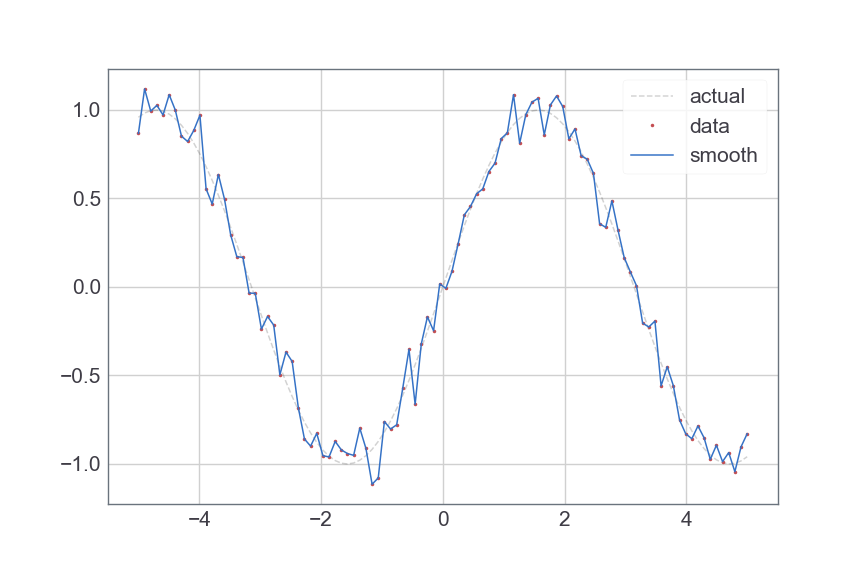

A Jupyter Widget

In [92]:
smooth_plot()